# Multithreading y Multiprocessing

En este Notebook se mostrará la diferencia en tiempos de ejecución entre un programa escrito con la librería `multithreading` y la `multiprocessing`.

Para llevar a cabo este estudio se usará como aplicación ejemplo [El juego de la vida de Conway](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life).

## Conociendo el entorno

Inicialmente vamos a conocer cuantos núcleos nos ofrecen en este entorno de Notebook en Google Colab.

In [10]:
!pip install numpy

  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/28/75/3b679b41713bb60e2e8f6e2f87be72c971c9e718b1c17b8f8749240ddca8/numpy-1.26.2-cp312-cp312-win_amd64.whl.metadata
     ---------------------------------------- 0.0/61.2 kB ? eta -:--:--
     ------------ ------------------------- 20.5/61.2 kB 320.0 kB/s eta 0:00:01
     -------------------------------------- 61.2/61.2 kB 542.2 kB/s eta 0:00:00
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/15.5 MB 2.6 MB/s eta 0:00:07
    --------------------------------------- 0.2/15.5 MB 3.8 MB/s eta 0:00:05
   - -------------------------------------- 0.7/15.5 MB 6.3 MB/s eta 0:00:03
   --- ------------------------------------ 1.3/15.5 MB 8.1 MB/s eta 0:00:02
   ----- ---------------------------------- 2.3/15.5 MB 11.3 MB/s eta 0:00:02
   -------- ------------------------------- 3.3/15.5 MB 13.1 MB/s eta 0:00:01
   ---------- ---------------


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
!pip install matplotlib

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/2e/51/c77a14869b7eb9d6fb440e811b754fc3950d6868c38ace57d0632b674415/matplotlib-3.8.2-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/8e/ae/a6353db548bff1a592b85ae6bb80275f0a51dc25a0410d059e5b33183e36/contourpy-1.2.0-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/ea/1e/a944a93c33e5cf495b0eb0c5e7e81f707c6b4d0dc5e54fb38ad2734da762/fonttools-4.46.0-cp312-cp312-win_amd64.whl.metadata
     ---------------------------------------- 0.0/159.4 kB ? eta -:--:--
     -- ------------------------------------- 10.2/159.4 kB ? eta -:-


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
#
# Tomado de: https://superfastpython.com/number-of-cpus-python/#CPU_Count_with_multiprocessingcpu_count
#
from multiprocessing import cpu_count

n_cores = cpu_count()

print(f'Numero de CPUs lógicas: {n_cores}')

Numero de CPUs lógicas: 12


## Código del juego de la vida de Conway

En esta sección se verán algunas implementaciones del algoritmo del juego de la vida de Conway.
Inicialmente se verá una versión secuencial, luego se introducirán los elementos para que esta versión secuencial se ejecute con el módulo de `multithreading` y luego `multiprocessing`.

### Versión secuencial


[1 1 1 ... 1 0 0]
[0 0 0 ... 1 0 0]
El tiempo que tomó calcular 0.7558653354644775


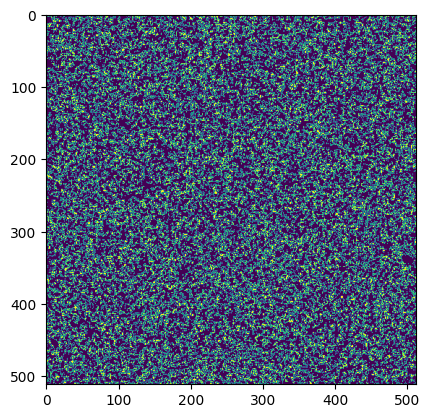

In [14]:
# Version SECUENCIAL del juego de la vida de Conway
#
# Autor: John Sanabria - john.sanabria@correounivalle.edu.co
# Fecha: 2023-02-22

import numpy as np
from time import time

import matplotlib.pyplot as plt

MAX_X = 512
MAX_Y = 512

#
# Funciones auxiliares usadas para estimar los vecinos de una celda y
# garantizar que los valores del borde no se vayan a sobrepasar
#
def posx(x, max_x = MAX_X):
  return (x + max_x) % max_x

def posy(y, max_y = MAX_Y):
  return (y + max_y) % max_y

def indice(x,y, max_y = MAX_Y):
  return posx(x) * max_y + posy(y)

#
# Esta funcion se encarga de contar los 8 vecinos de una celda cuales están
# vivos (valor a '1') o cuantos están muertos (valor a '0')
#
#                 |                |
#  (X - 1, Y - 1) | (  X  , Y - 1) | (X + 1, Y - 1)
#                 |                |
# --------------------------------------------------
#                 |                |
#  (X - 1,   Y  ) | (  X  ,   Y  ) | (X + 1,   Y  )
#                 |                |
# --------------------------------------------------
#                 |                |
#  (X - 1, Y + 1) | (  X  , Y + 1) | (X + 1, Y + 1)
#                 |                |

def vecinos(x,y,vector):
  return vector[ indice(x - 1, y - 1) ] + vector[ indice(x - 1, y) ] + vector[ indice(x - 1, y + 1) ] \
  + vector[ indice(x, y - 1) ] + vector[ indice(x, y + 1) ] \
  + vector[ indice(x + 1, y - 1) ] + vector[ indice(x + 1, y) ] + vector[ indice(x + 1, y + 1) ]
#
# Esta función se encarga de recorrer toda las celdas y estimar cuales de ellas
# vivirán y cuales no
#
def conway(vector_out, vector_in, low_limit = 0, high_limit = MAX_X):
  for i in range(low_limit,high_limit):
    for j in range(0,MAX_Y):
      n = vecinos(i,j, vector_in)
      valor = 0
      if vector_in[ indice(i,j) ] == 1 and (n == 2 or n == 3):
        valor = 1
      elif vector_in[ indice(i,j) ] == 0 and n == 3:
        valor = 1
      vector_out[ indice(i,j) ] = valor

#
# Función principal
#
if __name__ == '__main__':
  vector = np.int32( np.random.choice([1,0], MAX_X * MAX_Y, p = [0.50, 0.50]) )
  vector_out = np.empty(MAX_X * MAX_Y, dtype = np.int32)
  print(vector)
  t1 = time()
  conway(vector_out, vector)
  t2 = time()
  print(vector_out)
  print(f"El tiempo que tomó calcular {t2 - t1}")
  fig = plt.figure()
  plt.imshow(vector_out.reshape(MAX_X,MAX_Y))
  plt.show()

### Versión multithreading

[0 1 1 ... 1 0 1]
[1 1 1 ... 0 0 0]
El tiempo que tomó calcular 3.0699026584625244


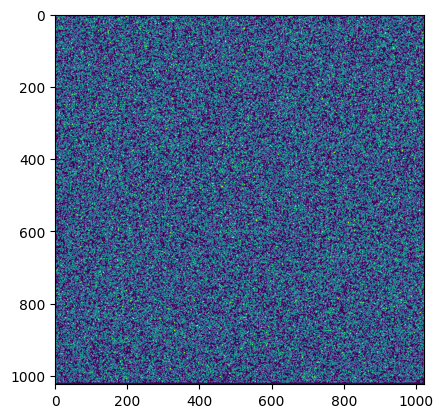

In [15]:
# Version MULTITHREADING del juego de la vida de Conway
#
# Autor: John Sanabria - john.sanabria@correounivalle.edu.co
# Fecha: 2023-02-22

import numpy as np
from threading import Thread
from multiprocessing import cpu_count
from time import time

import matplotlib.pyplot as plt

MAX_UNITS = cpu_count()
MAX_X = 1024
MAX_Y = 1024

#
# Funciones auxiliares usadas para estimar los vecinos de una celda y
# garantizar que los valores del borde no se vayan a sobrepasar
#

def posx(x, max_x = MAX_X):
  return (x + max_x) % max_x

def posy(y, max_y = MAX_Y):
  return (y + max_y) % max_y

def indice(x,y, max_y = MAX_Y):
  return posx(x) * max_y + posy(y)

#
# Esta funcion se encarga de contar los 8 vecinos de una celda cuales están
# vivos (valor a '1') o cuantos están muertos (valor a '0')
#
#                 |                |
#  (X - 1, Y - 1) | (  X  , Y - 1) | (X + 1, Y - 1)
#                 |                |
# --------------------------------------------------
#                 |                |
#  (X - 1,   Y  ) | (  X  ,   Y  ) | (X + 1,   Y  )
#                 |                |
# --------------------------------------------------
#                 |                |
#  (X - 1, Y + 1) | (  X  , Y + 1) | (X + 1, Y + 1)
#

def vecinos(x,y,vector):
  return vector[ indice(x - 1, y - 1) ] + vector[ indice(x - 1, y) ] + vector[ indice(x - 1, y + 1) ] \
  + vector[ indice(x, y - 1) ] + vector[ indice(x, y + 1) ] \
  + vector[ indice(x + 1, y - 1) ] + vector[ indice(x + 1, y) ] + vector[ indice(x + 1, y + 1) ]
#
# Esta función se encarga de recorrer toda las celdas y estimar cuales de ellas
# vivirán y cuales no
#
def conway(vector_out, vector_in, low_limit = 0, high_limit = MAX_X):
  for i in range(low_limit,high_limit):
    for j in range(0,MAX_Y):
      n = vecinos(i,j, vector_in)
      valor = 0
      if vector_in[ indice(i,j) ] == 1 and (n == 2 or n == 3):
        valor = 1
      elif vector_in[ indice(i,j) ] == 0 and n == 3:
        valor = 1
      vector_out[ indice(i,j) ] = valor

#
# Función principal
#
if __name__ == '__main__':
  vector = np.int32( np.random.choice([1,0], MAX_X * MAX_Y, p = [0.50, 0.50]) )
  vector_out = np.empty(MAX_X * MAX_Y, dtype = np.int32)
  print(vector)
  # Variables usadas para hacer la partición de las filas que procesara cada
  # hilo
  stride = np.int32(MAX_X / MAX_UNITS)
  count = np.int32(0)
  workers = [] # arreglo que almacenará aquellos hilos que se ejecutan
  for t in range(MAX_UNITS):
    worker = Thread(target = conway,
                    args = (vector_out, vector, count, count + stride))
    worker.daemon = True
    workers.append(worker)
    count = count + stride

  t1 = time()
  for worker in workers:
    worker.start()
  # Ciclo que espera por la terminación de todos los hilos que se lanzaron
  for worker in workers:
    worker.join()
  t2 = time()
  print(vector_out)
  print(f"El tiempo que tomó calcular {t2 - t1}")
  fig = plt.figure()
  plt.imshow(vector_out.reshape(MAX_X,MAX_Y))
  plt.show()

### Versión multiprocessing

[[0 1 1 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [1 1 0 ... 0 1 0]
 ...
 [1 0 0 ... 1 1 0]
 [0 0 1 ... 1 1 0]
 [0 1 1 ... 0 1 0]]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
El tiempo que tomó calcular 0.12151932716369629
La posicion (3,3) paso de 0 a 0
Sus vecinos eran
0, 1, 0
1, X, 0
0, 1, 0


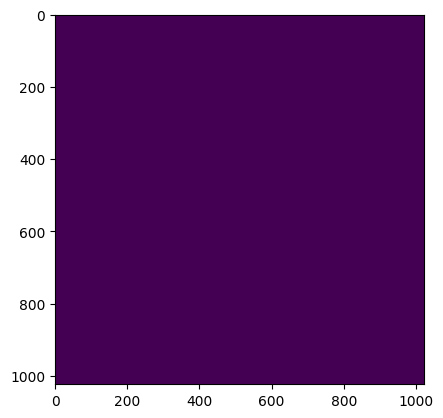

In [17]:
# Version MULTIPROCESSING del juego de la vida de Conway
#
# Autor: John Sanabria - john.sanabria@correounivalle.edu.co
# Fecha: 2023-02-22

import numpy as np
from multiprocessing import Process
from multiprocessing import cpu_count
from multiprocessing import RawArray
from time import time

import matplotlib.pyplot as plt

MAX_UNITS = cpu_count()
MAX_X = 1024
MAX_Y = 1024

_vector = np.int32( np.random.choice([1,0], MAX_X * MAX_Y, p = [0.50, 0.50]) )
vector = RawArray('i',_vector)
_vector_out = np.empty(MAX_X * MAX_Y, dtype = np.int32)
vector_out = RawArray('i',_vector_out)

#
# Funciones auxiliares usadas para estimar los vecinos de una celda y
# garantizar que los valores del borde no se vayan a sobrepasar
#

def posx(x, max_x = MAX_X):
  return (x + max_x) % max_x

def posy(y, max_y = MAX_Y):
  return (y + max_y) % max_y

def indice(x,y, max_y = MAX_Y):
  return posx(x) * max_y + posy(y)

#
# Esta funcion se encarga de contar los 8 vecinos de una celda cuales están
# vivos (valor a '1') o cuantos están muertos (valor a '0')
#
#                 |                |
#  (X - 1, Y - 1) | (  X  , Y - 1) | (X + 1, Y - 1)
#                 |                |
# --------------------------------------------------
#                 |                |
#  (X - 1,   Y  ) | (  X  ,   Y  ) | (X + 1,   Y  )
#                 |                |
# --------------------------------------------------
#                 |                |
#  (X - 1, Y + 1) | (  X  , Y + 1) | (X + 1, Y + 1)
#

def vecinos(x,y):
  return vector[ indice(x - 1, y - 1) ] + vector[ indice(x - 1 , y) ] + vector[ indice(x - 1, y + 1) ] \
  + vector[ indice(x, y - 1) ] + vector[ indice(x, y + 1) ] \
  + vector[ indice(x + 1, y - 1) ] + vector[ indice(x + 1 , y) ] + vector[ indice(x + 1, y + 1) ]

def imprimir_vecinos(x,y):
    print(f"La posicion ({x},{y}) paso de {vector[indice(x,y)]} a {vector_out[indice(x,y)]}")
    print("Sus vecinos eran")
    print(f"{vector[ indice(x - 1, y - 1) ]}, {vector[ indice(x - 1, y) ]}, {vector[ indice(x - 1, y + 1)]}")
    print(f"{vector[ indice(x, y - 1) ]}, X, {vector[ indice(x, y + 1) ]}")
    print(f"{vector[ indice(x + 1, y - 1) ]}, {vector[ indice(x + 1, y) ]}, {vector[ indice(x + 1, y + 1) ]}")

#
# Esta función se encarga de recorrer toda las celdas y estimar cuales de ellas
# vivirán y cuales no
#
def conway(low_limit = 0, high_limit = MAX_X):
  #print(f"De fila {low_limit} a fila {high_limit}")
  for i in range(low_limit,high_limit):
    for j in range(0,MAX_Y):
      n = vecinos(i,j)
      valor = 0
      if vector[ indice(i,j) ] == 1 and (n == 2 or n == 3):
        valor = 1
      elif vector[ indice(i,j) ] == 0 and n == 3:
        valor = 1
      vector_out[ indice(i,j) ] = valor

#
# Función principal
#
if __name__ == '__main__':
  #print(np.frombuffer(vector, dtype = np.int32))
  print(np.frombuffer(vector, dtype = np.int32).reshape(MAX_X, MAX_Y))
  # Variables usadas para hacer la partición de las filas que trabajará cada
  # proceso
  stride = np.int32(MAX_X / MAX_UNITS)
  count = np.int32(0)
  workers = [] # arreglo que almacenará aquellos procesos que se crearán
  for t in range(MAX_UNITS):
    worker = Process(target = conway,
                    args = (count, np.int32(count + stride)))
    workers.append(worker)
    #print(count)
    count = count + stride
  # Ciclo que lanza la ejecución de los procesos que se crearon
  t1 = time()
  for worker in workers:
    worker.start()
  # Ciclo que espera por la terminación de todos los procesos que se lanzaron
  for worker in workers:
    worker.join()
  t2 = time()
  print()
  print(np.frombuffer(vector_out, dtype = np.int32).reshape(MAX_X, MAX_Y))
  print(f"El tiempo que tomó calcular {t2 - t1}")
  imprimir_vecinos(3,3)
  fig = plt.figure()
  plt.imshow(np.frombuffer(vector_out, dtype=np.int32).reshape(MAX_X,MAX_Y))
  plt.show()

00.........10.........20.........30.........40.........50.........60.........70.........80.........90.........100.........110.........120.........130.........140.........150.........160.........170.........180.........190.........200.........210.........220.........230.........240.........

0

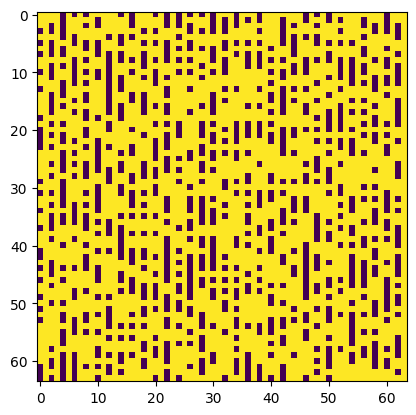

In [17]:
# Version MULTIPROCESSING del juego de la vida de Conway con ANIMACIÓN
#
# Autor: John Sanabria - john.sanabria@correounivalle.edu.co
# Fecha: 2023-02-22

import numpy as np
from multiprocessing import Process
from multiprocessing import cpu_count
from multiprocessing import RawArray
from time import time

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

MAX_UNITS = cpu_count() # número de trabajadores disponibles
MAX_X = 64 # dimensión en X de la grilla
MAX_Y = 64 # dimensión en Y de la grilla
stride = np.int32(MAX_X / MAX_UNITS)
PRINT_X_EACH = 10 # Cada cuanto imprimir una 'X' para mostrar el progreso

_vector = np.int32( np.random.choice([1,0], MAX_X * MAX_Y, p = [0.50, 0.50]) ) # Vector inicial NumPy
vector = RawArray('i',_vector) # Vector inicial pero compartible en el contexto de Multiprocessing
_vector_out = np.empty(MAX_X * MAX_Y, dtype = np.int32) # Vector después de una iteración
vector_out = RawArray('i',_vector_out) # Vector después de una iteración compartible en Multiprocessing

#
# Preparar variables para la visualización de los datos
#
fig, ax = plt.subplots()
image = ax.imshow(np.frombuffer(vector,dtype=np.int32).reshape(MAX_X,MAX_Y))

#
# Funciones auxiliares usadas para estimar los vecinos de una celda y
# garantizar que los valores del borde no se vayan a sobrepasar
#

def posx(x, max_x = MAX_X):
  return (x + max_x) % max_x

def posy(y, max_y = MAX_Y):
  return (y + max_y) % max_y

def indice(x,y, max_y = MAX_Y):
  return posx(x) * max_y + posy(y)

#
# Esta funcion se encarga de contar los 8 vecinos de una celda cuales están
# vivos (valor a '1') o cuantos están muertos (valor a '0')
#
#                 |                |
#  (X - 1, Y - 1) | (  X  , Y - 1) | (X + 1, Y - 1)
#                 |                |
# --------------------------------------------------
#                 |                |
#  (X - 1,   Y  ) | (  X  ,   Y  ) | (X + 1,   Y  )
#                 |                |
# --------------------------------------------------
#                 |                |
#  (X - 1, Y + 1) | (  X  , Y + 1) | (X + 1, Y + 1)
#

def vecinos(x,y):
  return vector[ indice(x - 1, y - 1) ] + vector[ indice(x - 1 , y) ] + vector[ indice(x - 1, y + 1) ] \
  + vector[ indice(x, y - 1) ] + vector[ indice(x, y + 1) ] \
  + vector[ indice(x + 1, y - 1) ] + vector[ indice(x + 1 , y) ] + vector[ indice(x + 1, y + 1) ]

def imprimir_vecinos(x,y):
    print(f"La posicion ({x},{y}) paso de {vector[indice(x,y)]} a {vector_out[indice(x,y)]}")
    print("Sus vecinos eran")
    print(f"{vector[ indice(x - 1, y - 1) ]}, {vector[ indice(x - 1, y) ]}, {vector[ indice(x - 1, y + 1)]}")
    print(f"{vector[ indice(x, y - 1) ]}, X, {vector[ indice(x, y + 1) ]}")
    print(f"{vector[ indice(x + 1, y - 1) ]}, {vector[ indice(x + 1, y) ]}, {vector[ indice(x + 1, y + 1) ]}")

#
# Esta función se encarga de recorrer toda las celdas y estimar cuales de ellas
# vivirán y cuales no
#
def conway(low_limit = 0, high_limit = MAX_X):
  for i in range(low_limit,high_limit):
    for j in range(0,MAX_Y):
      n = vecinos(i,j)
      valor = 0
      if vector[ indice(i,j) ] == 1 and (n == 2 or n == 3):
        valor = 1
      elif vector[ indice(i,j) ] == 0 and n == 3:
        valor = 1
      vector_out[ indice(i,j) ] = valor

#
# Esta función es la que se encarga de llevar a cabo la aplicación de la
# función de Conway en paralelo sobre los elementos de la grilla. Usando la
# librería Multiprocessing se lleva a cabo el procesamiento paralelo
#
def nueva_generacion(i):
  count = np.int32(0)
  workers = [] # arreglo que almacenará aquellos procesos que se crearán
  # Creación de los procesos
  for t in range(MAX_UNITS):
    worker = Process(target = conway,
                    args = (count, np.int32(count + stride)))
    workers.append(worker)
    count = count + stride
  # Ciclo que lanza la ejecución de los procesos que se crearon
  for worker in workers:
    worker.start()
  # Ciclo que espera por la terminación de todos los procesos que se lanzaron
  for worker in workers:
    worker.join()
  if i % PRINT_X_EACH == 0:
    print(f"{i}",end="")
  else:
    print(".",end="")


def actualizar_imagen(i):
    nueva_generacion(i)
    vector[:] = vector_out[:]
    image.set_data(np.frombuffer(vector,dtype=np.int32).reshape(MAX_X,MAX_Y))

#
# Función principal
#
if __name__ == '__main__':
  anim = FuncAnimation(fig, actualizar_imagen, frames=250, interval=100)
  html = HTML(anim.to_jshtml())
  display(html)

## Versión dispy

Result: 0 [0 0 1 ... 0 0 0] 0 42
Result: 1 [0 0 0 ... 0 0 0] 42 84
Result: 2 [0 0 0 ... 0 0 0] 84 126
Result: 3 [0 0 0 ... 0 0 0] 126 168
Result: 4 [0 0 0 ... 0 0 0] 168 210
Result: 5 [0 0 0 ... 0 0 0] 210 252
Result: 6 [0 0 0 ... 0 0 0] 252 294
Result: 7 [0 0 0 ... 0 0 0] 294 336
Result: 8 [0 0 0 ... 0 0 0] 336 378
Result: 9 [0 0 0 ... 0 0 0] 378 420
Result: 10 [0 0 0 ... 0 0 0] 420 462
Result: 11 [0 0 0 ... 0 0 0] 462 512

            Node |  CPUs |    Jobs |  Sec/Job | Node Time Sec |    Sent |    Rcvd
---------------------------------------------------------------------------------
 DESKTOP-NEJ0TUM |    12 |      12 |      1.0 |          11.7 | 293.5 M | 149.4 M

Total job time: 11.663 sec, wall time: 2.254 sec, speedup: 5.173

[0 0 1 ... 0 0 0]


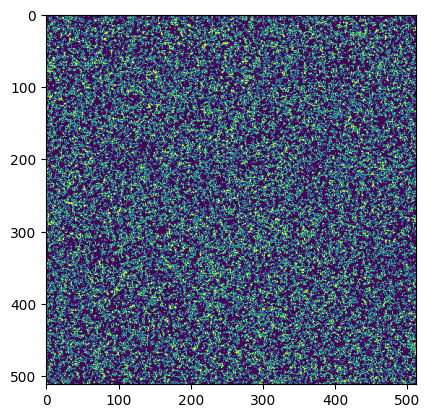

In [50]:
# Version PARALELA usando DISPY del juego de la vida de Conway
#
# Autores: Jesús Peña - jesus.guetio@correounivalle.edu.co
#          Diana Cadena - 
#          Marlon Anacona - 
# Fecha: 2023-12-09

import numpy as np
from time import time
from multiprocessing import cpu_count


import matplotlib.pyplot as plt
MAX_UNIT = cpu_count()
MAX_X = 512
MAX_Y = 512

#
# Funciones auxiliares usadas para estimar los vecinos de una celda y
# garantizar que los valores del borde no se vayan a sobrepasar
#
def posx(x, max_x = MAX_X):
  return (x + max_x) % max_x

def posy(y, max_y = MAX_Y):
  return (y + max_y) % max_y

def indice(x,y, max_y = MAX_Y):
  return posx(x) * max_y + posy(y)

#
# Esta funcion se encarga de contar los 8 vecinos de una celda cuales están
# vivos (valor a '1') o cuantos están muertos (valor a '0')
#
#                 |                |
#  (X - 1, Y - 1) | (  X  , Y - 1) | (X + 1, Y - 1)
#                 |                |
# --------------------------------------------------
#                 |                |
#  (X - 1,   Y  ) | (  X  ,   Y  ) | (X + 1,   Y  )
#                 |                |
# --------------------------------------------------
#                 |                |
#  (X - 1, Y + 1) | (  X  , Y + 1) | (X + 1, Y + 1)
#                 |                |

def vecinos(x,y,vector):
  return vector[ indice(x - 1, y - 1) ] + vector[ indice(x - 1, y) ] + vector[ indice(x - 1, y + 1) ] \
  + vector[ indice(x, y - 1) ] + vector[ indice(x, y + 1) ] \
  + vector[ indice(x + 1, y - 1) ] + vector[ indice(x + 1, y) ] + vector[ indice(x + 1, y + 1) ]
#
# Esta función se encarga de recorrer toda las celdas y estimar cuales de ellas
# vivirán y cuales no
#
def calcular_conway(low_limit, high_limit, vector_in):
    import numpy as np
    MAX_Y = 512
    MAX_X = 512
    # Crear vector_out para almacenar los resultados

    def posx(x, max_x = MAX_X):
        return (x + max_x) % max_x
        
    def posy(y, max_y = MAX_Y):
        return (y + max_y) % max_y
    
    def indice(x,y, max_y = MAX_Y):
        return posx(x) * max_y + posy(y)
    
    def vecinos(x,y,vector):
        return vector[ indice(x - 1, y - 1) ] + vector[ indice(x - 1, y) ] + vector[ indice(x - 1, y + 1) ] \
        + vector[ indice(x, y - 1) ] + vector[ indice(x, y + 1) ] \
        + vector[ indice(x + 1, y - 1) ] + vector[ indice(x + 1, y) ] + vector[ indice(x + 1, y + 1) ]

    # Aplicar las reglas de Conway en la sección dada del vector
    vector_out = np.zeros_like(vector_in)
    
    # Aplicar las reglas de Conway en la sección dada del vector
    for i in range(low_limit, high_limit):
        for j in range(0, MAX_Y):
            n = vecinos(i, j, vector_in)
            valor = 0
            if vector_in[indice(i, j)] == 1 and (n == 2 or n == 3):
                valor = 1
            elif vector_in[indice(i, j)] == 0 and n == 3:
                valor = 1
            vector_out[indice(i, j)] = valor
    
    return (vector_out, low_limit, high_limit)

if __name__ == '__main__':
    import dispy
    vector_in = np.random.randint(2, size=(MAX_X * MAX_Y))
    cluster = dispy.JobCluster(calcular_conway)

    # Dividir el trabajo en secciones para los nodos
    section_size = MAX_X //MAX_UNIT
    jobs = []
    for i in range(MAX_UNIT):
        low_limit = i * section_size
        high_limit = (i + 1) * section_size if i < MAX_UNIT - 1 else MAX_X
        job = cluster.submit(low_limit, high_limit, vector_in)
        job.id = i
        jobs.append(job)
    
    # Recopilar los resultados de los trabajos
    vector_out = np.zeros_like(vector_in)
    for job in jobs:
        result,low_limit,high_limit  = job()
        vector_out[MAX_Y*low_limit:MAX_Y*high_limit] = result[MAX_Y*low_limit:MAX_Y*high_limit]
        print("Result:",job.id,result,low_limit,high_limit)
        
    cluster.print_status()
    test_result = calcular_conway(0, 100, vector_in)
    #print("Resultado de prueba:", np.array2string(vector_out, threshold=np.inf))
    print(vector_out)
    fig = plt.figure()
    plt.imshow(vector_out.reshape(MAX_X,MAX_Y))
    plt.show()

In [19]:
# 'compute' is distributed to each node running 'dispynode'
def compute(n):
    import time
    time.sleep(n)
    # dispy_node_name is name of server where this computation is being executed
    return (dispy_node_name, n)

if __name__ == '__main__':
    import dispy, random
    cluster = dispy.JobCluster(compute)
    jobs = []
    for i in range(10):
        # schedule execution of 'compute' on a node (running 'dispynode')
        # with a parameter (random number in this case)
        job = cluster.submit(random.randint(5,20))
        job.id = i # optionally associate an ID to job (if needed later)
        jobs.append(job)
    # cluster.wait() # waits for all scheduled jobs to finish
    for job in jobs:
        result= job() # waits for job to finish and returns results
        print("Job:", result)
        # other fields of 'job' that may be useful:
        #print(job.stdout, job.stderr, job.exception, job.ip_addr, job.start_time, job.end_time)
    cluster.print_status()

Job: ('DESKTOP-NEJ0TUM', 7)
Job: ('DESKTOP-NEJ0TUM', 19)
Job: ('DESKTOP-NEJ0TUM', 13)
Job: ('DESKTOP-NEJ0TUM', 20)
Job: ('DESKTOP-NEJ0TUM', 8)
Job: ('DESKTOP-NEJ0TUM', 8)
Job: ('DESKTOP-NEJ0TUM', 17)
Job: ('DESKTOP-NEJ0TUM', 5)
Job: ('DESKTOP-NEJ0TUM', 17)
Job: ('DESKTOP-NEJ0TUM', 5)

            Node |  CPUs |    Jobs |  Sec/Job | Node Time Sec |    Sent |    Rcvd
---------------------------------------------------------------------------------
 DESKTOP-NEJ0TUM |    12 |      10 |     12.2 |         122.2 |  46.7 K |  60.2 K

Total job time: 122.190 sec, wall time: 20.363 sec, speedup: 6.000



In [18]:
import time
import dispy
import random

def compute(n):
    import random
    A = [[random.randint(0,100) for i in range(n)] for j in range(n)]
    total = 0
    for i in range(n):
        for j in range(n):
            total += A[i][j]
    return A

if __name__ == '__main__':
    import socket
    cluster = dispy.JobCluster(compute)
    for i in range(10):
        print(compute(i))
    jobs = []
    for i in range(10):
        job = cluster.submit(i)
        job.id = i
        jobs.append(job)

    for job in jobs:
        result = job()
        #print(job.stdout,job.exception, job.ip_addr)
        print("Job:",result)

    cluster.wait()
    cluster.print_status()
    cluster.close()

[]
[[91]]
[[6, 20], [74, 65]]
[[9, 42, 9], [86, 70, 28], [76, 48, 32]]
[[13, 0, 9, 55], [40, 77, 10, 66], [78, 37, 42, 51], [24, 34, 24, 80]]
[[88, 68, 82, 14, 92], [51, 26, 57, 45, 85], [13, 67, 39, 24, 34], [12, 56, 19, 100, 69], [6, 25, 57, 19, 88]]
[[64, 77, 11, 94, 46, 90], [57, 2, 5, 62, 58, 14], [59, 40, 72, 4, 60, 56], [17, 3, 40, 86, 91, 26], [92, 11, 56, 45, 94, 85], [42, 58, 83, 61, 5, 66]]
[[42, 0, 85, 6, 66, 40, 37], [3, 21, 29, 99, 24, 37, 28], [57, 5, 49, 63, 88, 97, 87], [27, 60, 73, 59, 11, 27, 44], [50, 73, 82, 58, 84, 0, 15], [13, 68, 83, 45, 83, 64, 15], [51, 24, 67, 29, 16, 69, 54]]
[[70, 34, 95, 60, 61, 6, 54, 2], [79, 41, 7, 38, 64, 27, 29, 48], [31, 68, 59, 37, 20, 4, 71, 79], [29, 77, 28, 11, 36, 33, 35, 71], [59, 34, 87, 66, 46, 78, 31, 92], [93, 25, 57, 91, 0, 86, 64, 5], [28, 77, 1, 52, 32, 33, 16, 75], [94, 22, 90, 73, 36, 24, 28, 96]]
[[2, 47, 44, 11, 23, 62, 26, 100, 64], [25, 67, 21, 90, 52, 60, 29, 67, 100], [31, 12, 85, 42, 8, 81, 43, 19, 41], [68, 75,